<a href="https://colab.research.google.com/github/AndrewChiyz/awesome-NeRF/blob/main/Tiny_nerf_demo_reading_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

--2021-03-26 08:16:48--  https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bmild.com/nerf/tiny_nerf_data.npz [following]
--2021-03-26 08:16:49--  https://bmild.com/nerf/tiny_nerf_data.npz
Resolving bmild.com (bmild.com)... 216.239.34.21, 216.239.32.21, 216.239.38.21, ...
Connecting to bmild.com (bmild.com)|216.239.34.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bmild.github.io/nerf/tiny_nerf_data.npz [following]
--2021-03-26 08:16:49--  https://bmild.github.io/nerf/tiny_nerf_data.npz
Resolving bmild.github.io (bmild.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bmild.github.io (bmild.github.io)|185.199.108.153|:443... connected.
HTTP re

# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


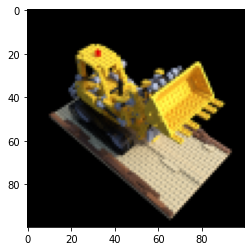

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

In [ ]:
print(poses[0,:,:])
print(focal)

[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
138.88887889922103


# Optimize NeRF

In [ ]:


def posenc(x):
  # pose encoding 
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

# Fourier feature mapping (coordinates mapping)
def guassian_mapping(x, B=10.0): 
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    # focal ? and c2w ? 
    # focal camera intrinsic paramerters, named as K
    # c2w camera extrinsics parameters, rotation matrix (R), and transform transformation (T) vector, 4x4 matrix
    # 
    # K [R|T][x, y, z, 1]^transpose = z * [u, v, 1]^transpose
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy') 
    # depth 
    # i:100x100, j:100x100
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    # dirs 100x100x3 
    # center, [x, y, 1] coordinates in image coordinates on the distance focal
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1) 
    #  rays_d: 100x100x3
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    #  rays_o, 
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    ## Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    ## get linspace of values range from near to far with interval 1/N_samples
    if rand:
      # get random noise, with far and near noramlization
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    ## get the pts in the same line with 
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    ## pts: 100, 100, 64, 3, for each point, and each ray, sample 64 points in that rays
    # Run network
    pts_flat = tf.reshape(pts, [-1,3]) # [640000, 3]
    pts_flat = embed_fn(pts_flat)      # [640000, 3*2*6+3]
    raw = batchify(network_fn)(pts_flat) 
    ## feed data into the network with batches
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4]) 
    ## why reshape?
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.17259770393371582 secs per iter


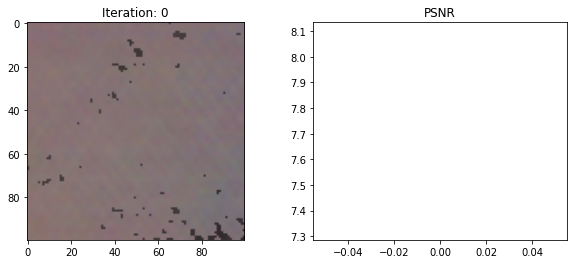

25 0.46082603454589843 secs per iter


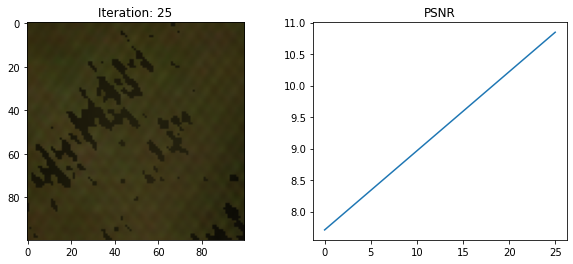

50 0.46495588302612306 secs per iter


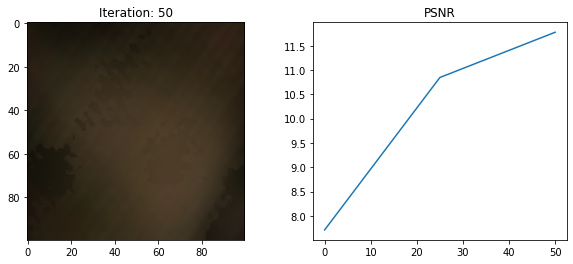

75 0.46030442237854 secs per iter


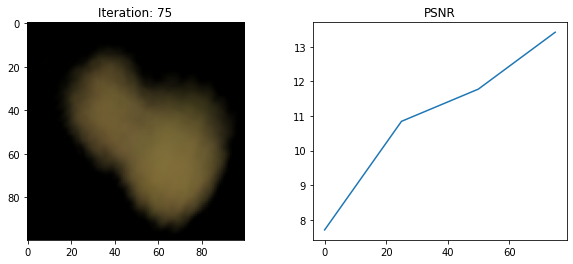

100 0.46065685272216794 secs per iter


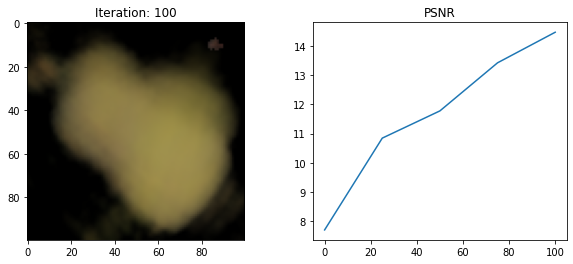

125 0.4611353015899658 secs per iter


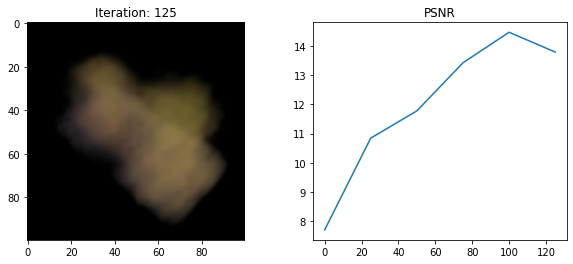

150 0.45976799964904785 secs per iter


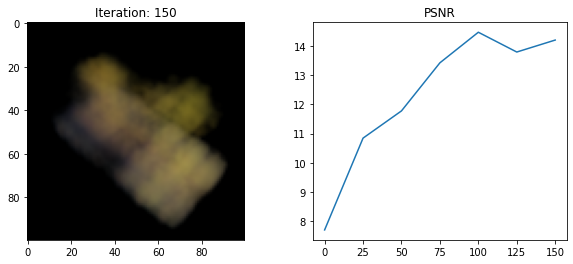

175 0.46457815170288086 secs per iter


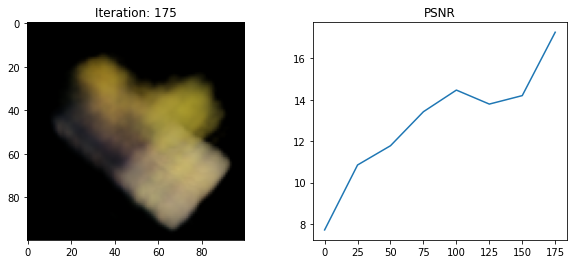

200 0.4592391872406006 secs per iter


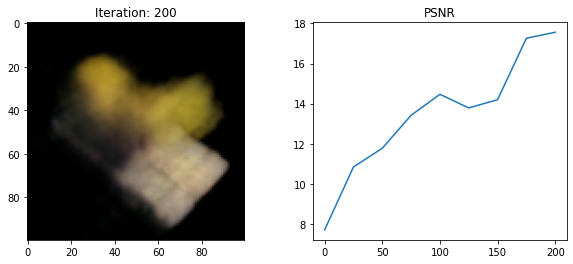

225 0.4595373725891113 secs per iter


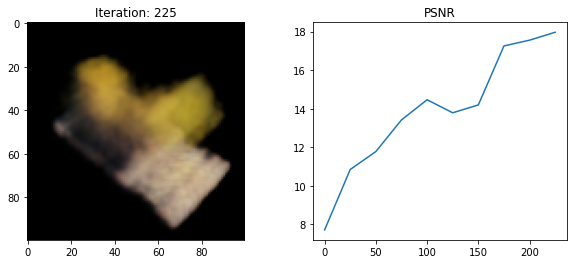

250 0.4605523681640625 secs per iter


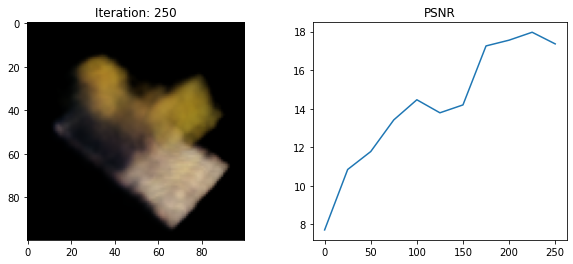

275 0.46341691017150877 secs per iter


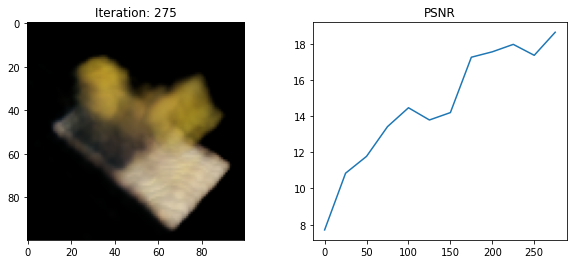

300 0.45980379104614255 secs per iter


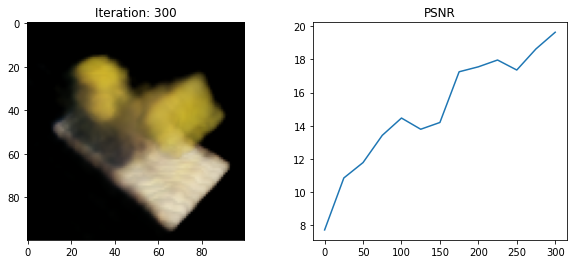

325 0.4597593879699707 secs per iter


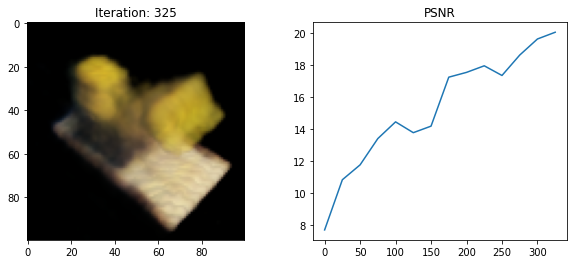

350 0.45971869468688964 secs per iter


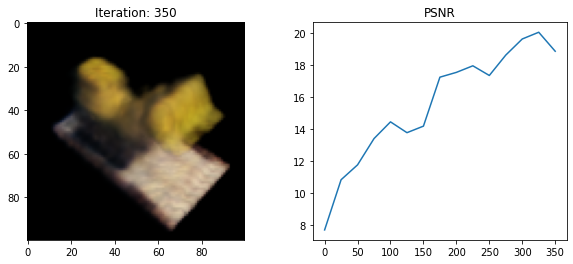

375 0.4603808689117432 secs per iter


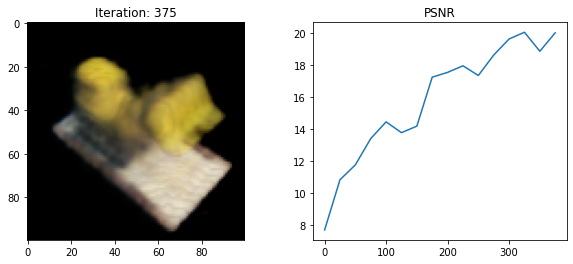

400 0.4654396438598633 secs per iter


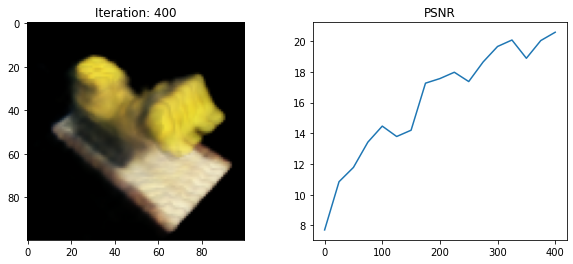

425 0.4598587226867676 secs per iter


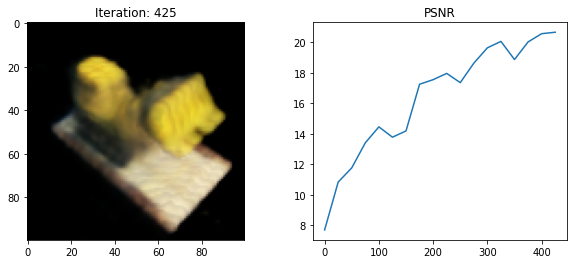

450 0.4600891399383545 secs per iter


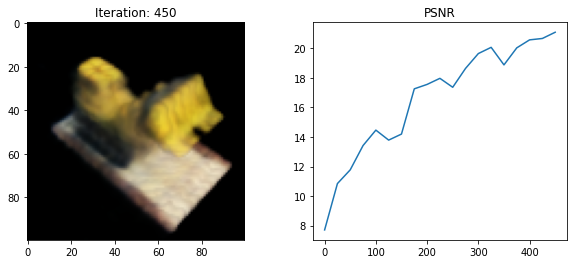

475 0.4598205852508545 secs per iter


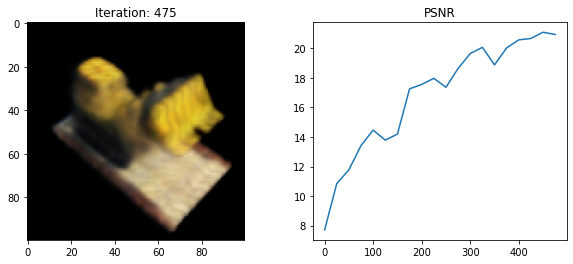

500 0.4604152011871338 secs per iter


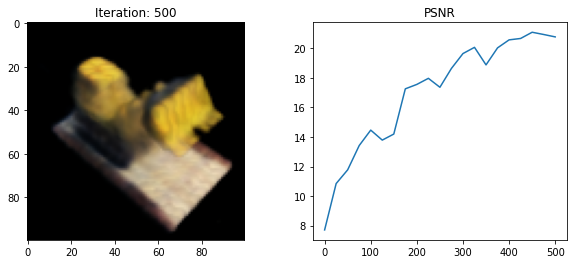

525 0.46387123107910155 secs per iter


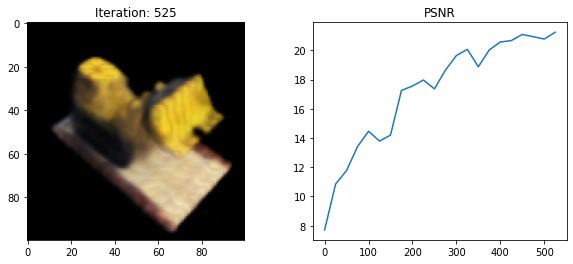

550 0.46001554489135743 secs per iter


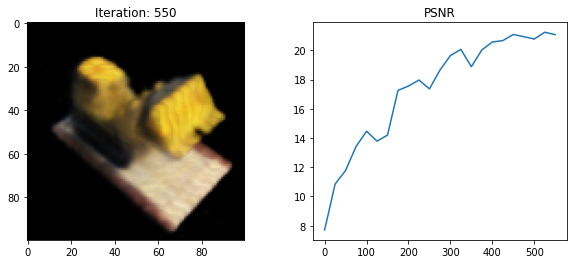

575 0.4614254379272461 secs per iter


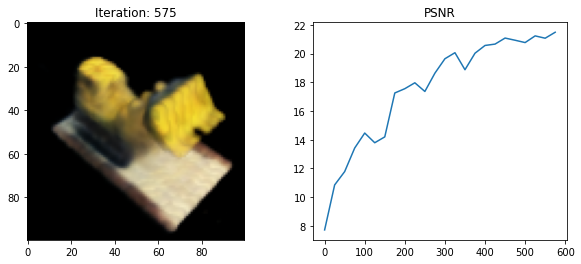

600 0.46018634796142577 secs per iter


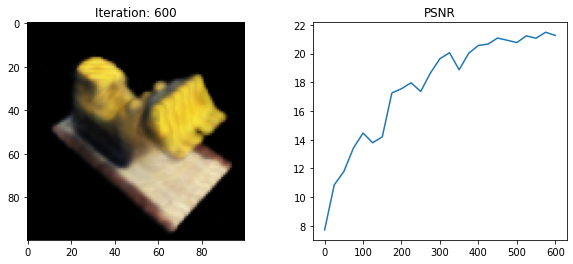

625 0.4648568916320801 secs per iter


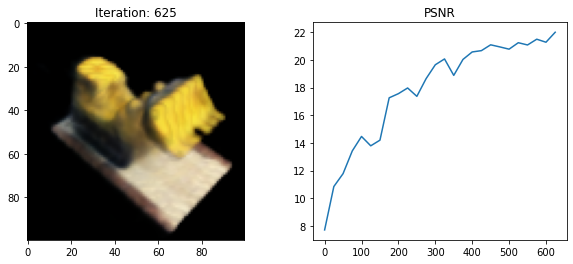

650 0.4606668949127197 secs per iter


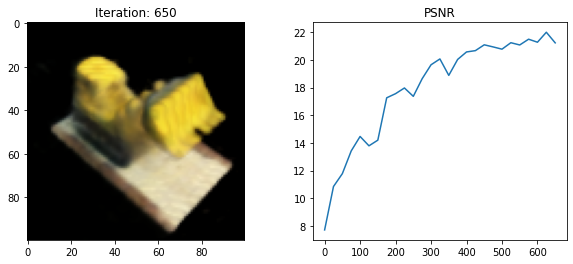

675 0.46135831832885743 secs per iter


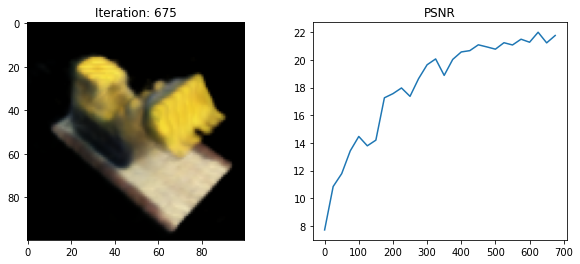

700 0.46103692054748535 secs per iter


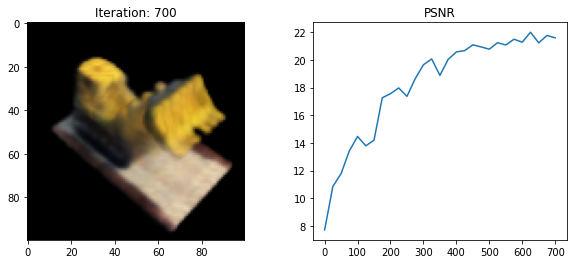

725 0.46009097099304197 secs per iter


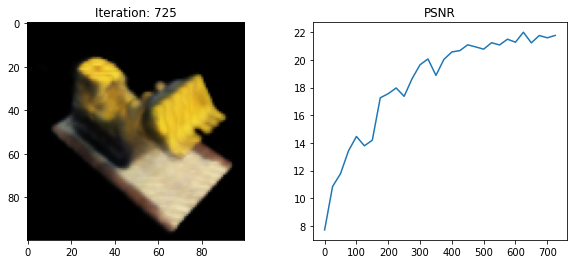

750 0.4653224277496338 secs per iter


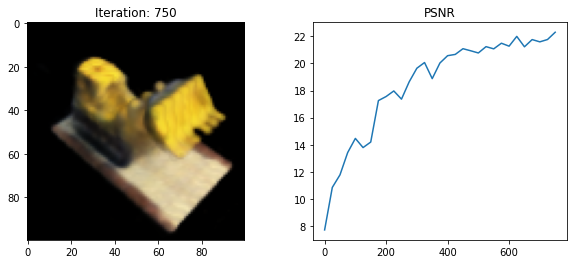

775 0.45978910446166993 secs per iter


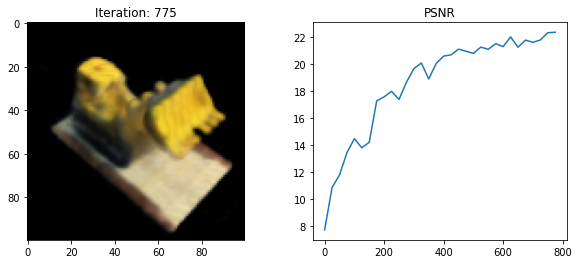

800 0.4600039482116699 secs per iter


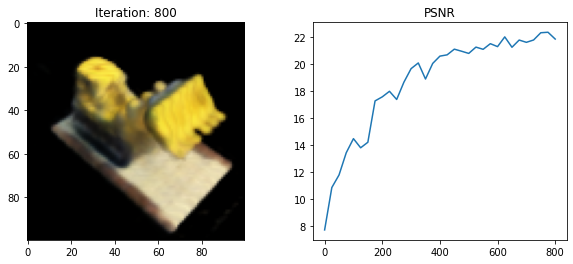

825 0.4600474262237549 secs per iter


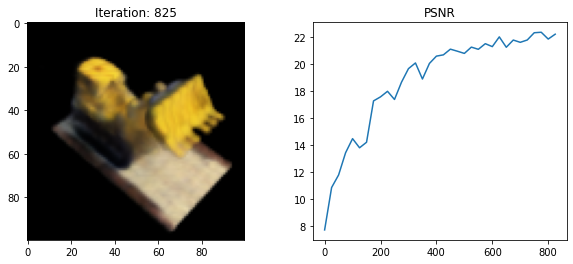

850 0.46423781394958497 secs per iter


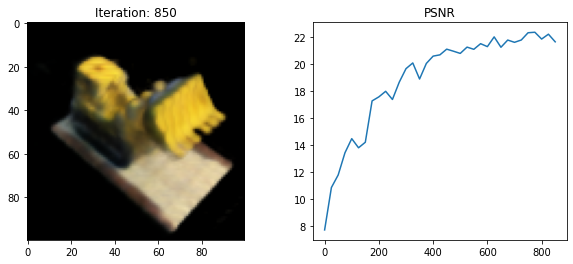

875 0.4606974792480469 secs per iter


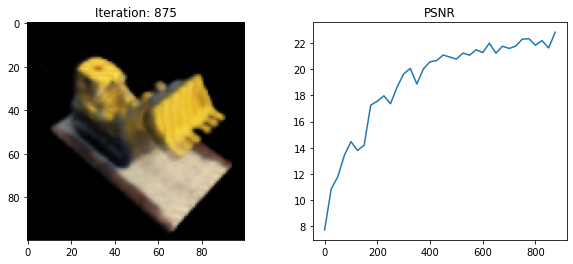

900 0.4599051284790039 secs per iter


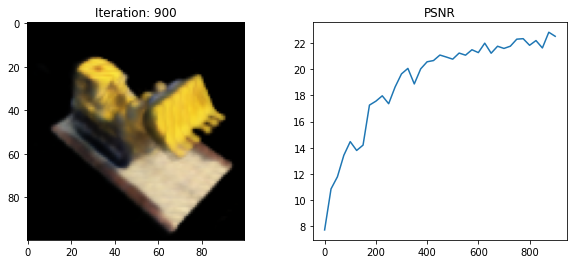

925 0.4606663990020752 secs per iter


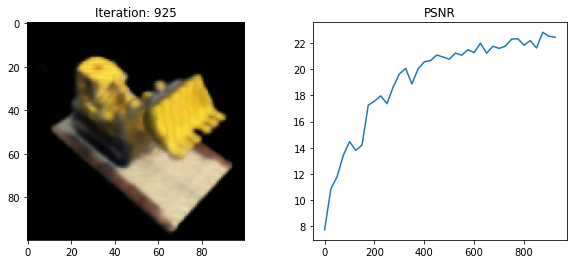

950 0.46036472320556643 secs per iter


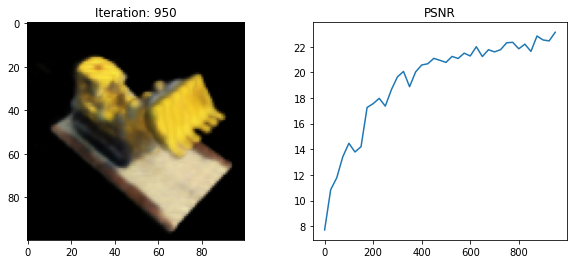

975 0.464231481552124 secs per iter


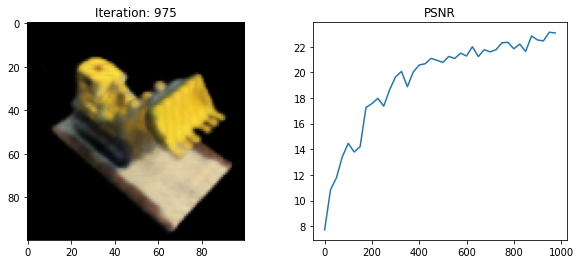

1000 0.4608926010131836 secs per iter


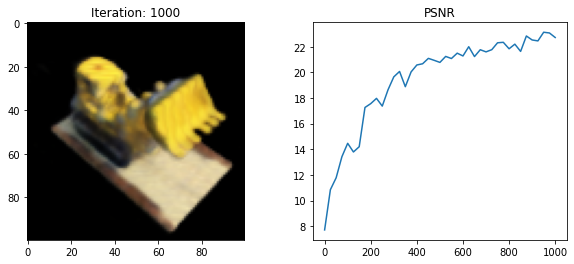

Done


In [ ]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i] # randomly select an image as target, for calculating loss
    pose = poses[img_i]    # select the corresponding cameras paramters
    # H, W is the size of image
    # focal is given, camera intrinsic 
    # pos : camera extrinsic, camera pose for this image
    rays_o, rays_d = get_rays(H, W, focal, pose) # according to the focal lenght and camera pose, get a ray
    # within the rays 
    with tf.GradientTape() as tape:
        # how to define the near and far
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose) # H, W, and testpose
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)